Whale optimization algorithm is a meta heuristic algorithm similar to grey wolf optimization. However, instead of a complete hierarchy, there is only a leader present, alll other search agents update their positions based on the position of leader. There is a continuous switching between exploration and exploitation. 

Here the fitness function is borrowed from Grey wolf optimization. 

In [1]:
# importing required libraries 
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(0)  # seeding for repeatable results

A note regarding the format of data that has been stored and manipulated. Each of the whale in this algorithm denote an entire configuration of source and receivers. Each whale is a 1D vector with index 0,1 representing the source position and then x,y (in that sequence) coordinates of each of the receiver in subsequent space.

In [2]:
# defining a suitable fitness function
n_rec = 51 # number of receivers
def fitness(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    pos_matrix.reshape((n_rec+1)*2)
    ToA_pos = np.zeros(shape=n_rec)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0]))  # vector denoting the position of receivers wrt source
    pos_diff_x= (pos_matrix[2::2] - pos_matrix[0])#.reshape(n_rec)  # x coordinate difference
    pos_diff_y= (pos_matrix[3::2] - pos_matrix[1])#.reshape(n_rec)
    ToA_pos[:] = np.sqrt(np.multiply(pos_diff_x,pos_diff_x)+ np.multiply(pos_diff_y,pos_diff_y))/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    return error

In [3]:
# Testing the fitness function with a simple case
pos_matrix = np.array([0,0,1,0,-2,0,0,0,0,0]) # source at (0,0), receiver at (1,1) and another reciver at [-2,0]
toa_actual = np.array([1,2]) # time taken will be 1s with wave velocity of 1 m/s
toa_given = np.array([1,0,0,0]) # for this case, the answer should come out to be 4 s^2


In [4]:
# Now generating the synthetic data for testing
wave_vel = 1 # m/s
rec_pos_actual =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec,2))  # actual position for 2 receivers
src_pos_actual = np.array([0,0])
t_rec_ideal = np.zeros(shape =(n_rec,1))
# calculating the ideal time of arrival
t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0]-src_pos_actual[0])**2).reshape(n_rec,1)
#introducing noise to account for error in onset detection and sensor
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
t_Rec_real = np.array(t_rec_ideal + noise_t)
t_max=max(t_Rec_real)
t_min=min(t_Rec_real)
src_upper_bound=t_max*wave_vel
src_lower_bound=t_min*wave_vel

In [5]:
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_whales = 32 # number of whales

initial_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_whales,(n_rec+1)*2))  # in order to make sure that the spread is in entire domain

In [6]:
n_iter = 500# number of iterations
estimated_positions = np.zeros((n_iter,2))



In [7]:
def Whale_optimization(n_iter,n_whales,initial_pos,t_Rec_real):
    '''The function returns the optimzed location for leader in the search space according to Whale Optimization algorithm.
    n_iter = number of iterations
    n_whales = number of whales
    initial_pos = initial position of all whales'''
    
    TOA_min = np.min(t_Rec_real)
    TOA_max = np.max(t_Rec_real)
    TOA_avg = np.mean(t_Rec_real)
    whales_pos = np.copy(initial_pos)  
    fitness_array =np.zeros(n_iter)
    individual_bound=25
    fitness_value = np.zeros(n_whales)
   
    # Assigning the position and fitness for leader
    n_rec = int(np.shape(initial_pos)[1]/2-1) # number of receiver
    leader_fitness = 10**10#fitness_value[0]
    leader_pos = np.copy(whales_pos[0]) 
    

        # Now updating the position
    for i in range(n_iter):  
        fitness_array[i] = leader_fitness
        # Defining parameters for updating positions
        a =  2 - i*2/n_iter# scalar
   # a2 = -1 + i*(-1/n_iter)  needed?
        for j in range(n_whales):
            r1 = np.random.random(size=(n_rec+1)*2)#vector       
            r2 = np.random.random(size=(n_rec+1)*2)#vector
            A = 2*a*r1 - a #vector
           
            C =2*r2#vector
           
            b = 1# may vary
            #l = (a2-1)*np.random.random() + 1       #needed?
            p = np.random.random()
            
            if p < 0.5:
                if np.dot(A,A) < 1:# mod A less than 1
                    D=np.absolute(np.multiply(C,leader_pos)-whales_pos[j])# prey interpreted as leader
                   
                    temp= leader_pos - np.multiply(A,D)
                    for x in range(2, n_rec*2+1):# skip bound on ource
                        if abs(temp[x] -whales_pos[j][x])<individual_bound:
                            whales_pos[j][x]=temp[x]
                    # the following needs modification
                    #to prevent whales from esaping boundaries
                   # if (whales_pos[j,k] > =350 or whales_pos[j,k] =<250 ):# currently specific, will need to generaliz
                      #  whales_pos[j,k] = 250 + 100*np.random.random()
                
                else: #if dot(A.A)>=1
                        random_whale_index = np.random.randint(low=0,high=n_whales)
                        Random_whale_pos = whales_pos[random_whale_index]
                        D=np.absolute(np.multiply(C,Random_whale_pos)-whales_pos[j])
                   
                        temp = Random_whale_pos - np.multiply(A,D)
                        for x in range(2, n_rec*2+1):
                            if abs(temp[x] -whales_pos[j][x])<individual_bound:
                                whales_pos[j][x]=temp[x]
                    # to prevent whales from escaping the boundaries
                   # if (whales_pos[j,k] > =350 or whales_pos[j,k] =<250) :# currently specific, will need to generaliz
                   #     whales_pos[j,k] = 250 + 100*np.random.random()                
            else :#if p>=0.5   best solution interpreted as leader
                D = np.absolute(leader_pos-whales_pos[j])
                t=np.random.uniform(-1,1)# "b" constant and defined much earlier
                temp=D*np.exp(b*t)*np.cos(2*np.pi*t)+ leader_pos[j]
                for x in range(2, n_rec*2+1):
                        if abs(temp[x] -whales_pos[j][x])<individual_bound:
                            whales_pos[j][x] =temp[x]
                
                
            for k in range(2,2*(n_rec+1)):
                if (whales_pos[j,k] >= 400 or whales_pos[j,k] <= 300 ):# currently specific, will need to generaliz
                    whales_pos[j,k] = 300 + 100*np.random.random()    
            
                if(np.sqrt((whales_pos[j,0])**2+ (whales_pos[j,0])**2)>=src_upper_bound + 300  or \
                   np.sqrt((whales_pos[j,0])**2+ (whales_pos[j,0])**2)<= src_lower_bound+300):
                    whales_pos[j,0]= (src_upper_bound + src_lower_bound)/2 + 50*np.random.random()
                    whales_pos[j,1]= (src_upper_bound + src_lower_bound)/2 + 50*np.random.random()
                        
                        
                        
          
        for j in range(n_whales):
                    fitness_value[j] = fitness(whales_pos[j,:],t_Rec_real,wave_vel = wave_vel)
                    if fitness_value[j] <= leader_fitness:
                        leader_fitness = fitness_value[j]
                        leader_pos = np.copy(whales_pos[j])
                        
                        
                      
        estimated_positions[i]=(leader_pos[0],leader_pos[1])  
       
                
    return leader_pos,fitness_array
        

In [8]:
final_pos, fitness_array = Whale_optimization(n_iter=n_iter,n_whales =n_whales,initial_pos = initial_pos,t_Rec_real=t_Rec_real)

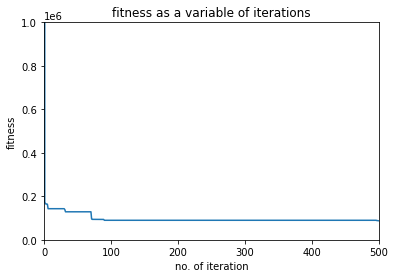

In [9]:
import matplotlib.pyplot as plt
index_of_iteration= list( range(0,n_iter))
plt.plot(index_of_iteration,fitness_array)
plt.xlabel("no. of iteration")
plt.ylabel("fitness")
plt.title("fitness as a variable of iterations")
plt.xlim(0,n_iter)
plt.ylim(-1,10**6)
plt.show()


In [10]:
final_receivers=np.zeros((n_rec,2))
initial_receivers=np.zeros((n_rec,2))
for i in range(1,n_rec):
    final_receivers[i]=(final_pos[2*i],final_pos[2*i+1])
for i in range(1,n_rec):
    initial_receivers[i]=(initial_pos[0][2*i],initial_pos[0][2*i+1])    


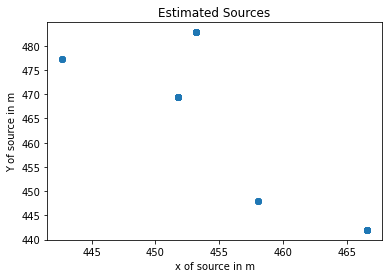

In [11]:
plt.xlabel("x of source in m")
plt.ylabel("Y of source in m")
plt.title("Estimated Sources")
plt.scatter(estimated_positions[:,0],estimated_positions[:,1])

#plt.xlim(np.min(estimated_positions[::0]),np.max(estimated_positions[::0]))
#plt.ylim(np.min(estimated_positions[::1]),np.max(estimated_positions[::1]))
plt.show()


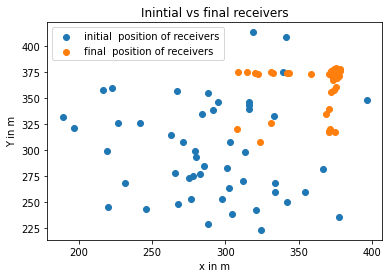

In [12]:
plt.xlabel("x in m")
plt.ylabel("Y in m")
plt.title("Inintial vs final receivers")
plt.scatter(initial_receivers[1:,0],initial_receivers[1:,1],label="initial  position of receivers")
plt.scatter(final_receivers[1:,0],final_receivers[1:,1],label="final  position of receivers")
plt.legend()
plt.show()
    
